In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [3]:
total_ped_matrix = np.load("../details/new_ped_matrix.npy")

with open("../details/ped_dataset.pkl", "rb") as f:
    ped_dataset = pickle.load(f)
    
with open('../details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../data/', \
                verbose=False)

In [4]:
so_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [4]:
# defining the custom rmse loss function
def rmse_loss(gt_path, pred_path):
    '''
    calculates custom rmse loss between every time point
    '''
    gt_path = tf.reshape(gt_path, [-1, 10, 2])
    pred_path = tf.reshape(pred_path, [-1, 10, 2])
    
    return K.sqrt(K.mean(K.square(gt_path-pred_path)))

In [5]:
# loading the model
fc_model = tf.keras.models.load_model("../checkpoints/lstm_best.hdf5", compile=False)

fc_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                 loss=rmse_loss, 
                 metrics=["accuracy"])

In [7]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = []
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss.append(((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5)
    
    loss = np.array(loss)
    return np.mean(loss)  

In [9]:
rmse_values = []
fde_valus = []

for test_idx in range(9800, 11056):
    test_data = total_ped_matrix[test_idx:test_idx+1,:6,:]
    predictions = fc_model.predict(test_data).reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_pedposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], 
#                     ped_path = np.array(ped_dataset[test_idx]["translation"])[:,:2], 
#                     verbose = False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss = rmse_error(predictions, 
                               np.array(ped_dataset[test_idx]["translation"])[6:,:2])
    
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])
    
    rmse_values.append(loss)
    fde_valus.append(final_loss)
    
print(f"RMSE Loss in m is {np.mean(np.array(rmse_values))}")
print(f"Loss of final position in m is {np.mean(np.array(fde_valus))}")

RMSE Loss in m is 0.22657292674779012
Loss of final position in m is 0.45030077775434874


In [18]:
feature_errors = []

for j in range(total_ped_matrix.shape[2]):
    trial_matrix = np.copy(total_ped_matrix)
    trial_matrix[9800:11056,:,j] = trial_matrix[11054:12310,:,j]
    rmse_values = []
    for test_idx in range(9800,11056):
        test_data = trial_matrix[test_idx:test_idx+1,:6,:]
        predictions = fc_model.predict(test_data).reshape(-1, 2)
        predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])
        loss = rmse_error(predictions, 
                               np.array(ped_dataset[test_idx]["translation"])[6:,:2])

        rmse_values.append(loss)
        
    feature_errors.append(np.mean(np.array(rmse_values)))
        
feature_importance = [l-0.2265729 for l in feature_errors]    

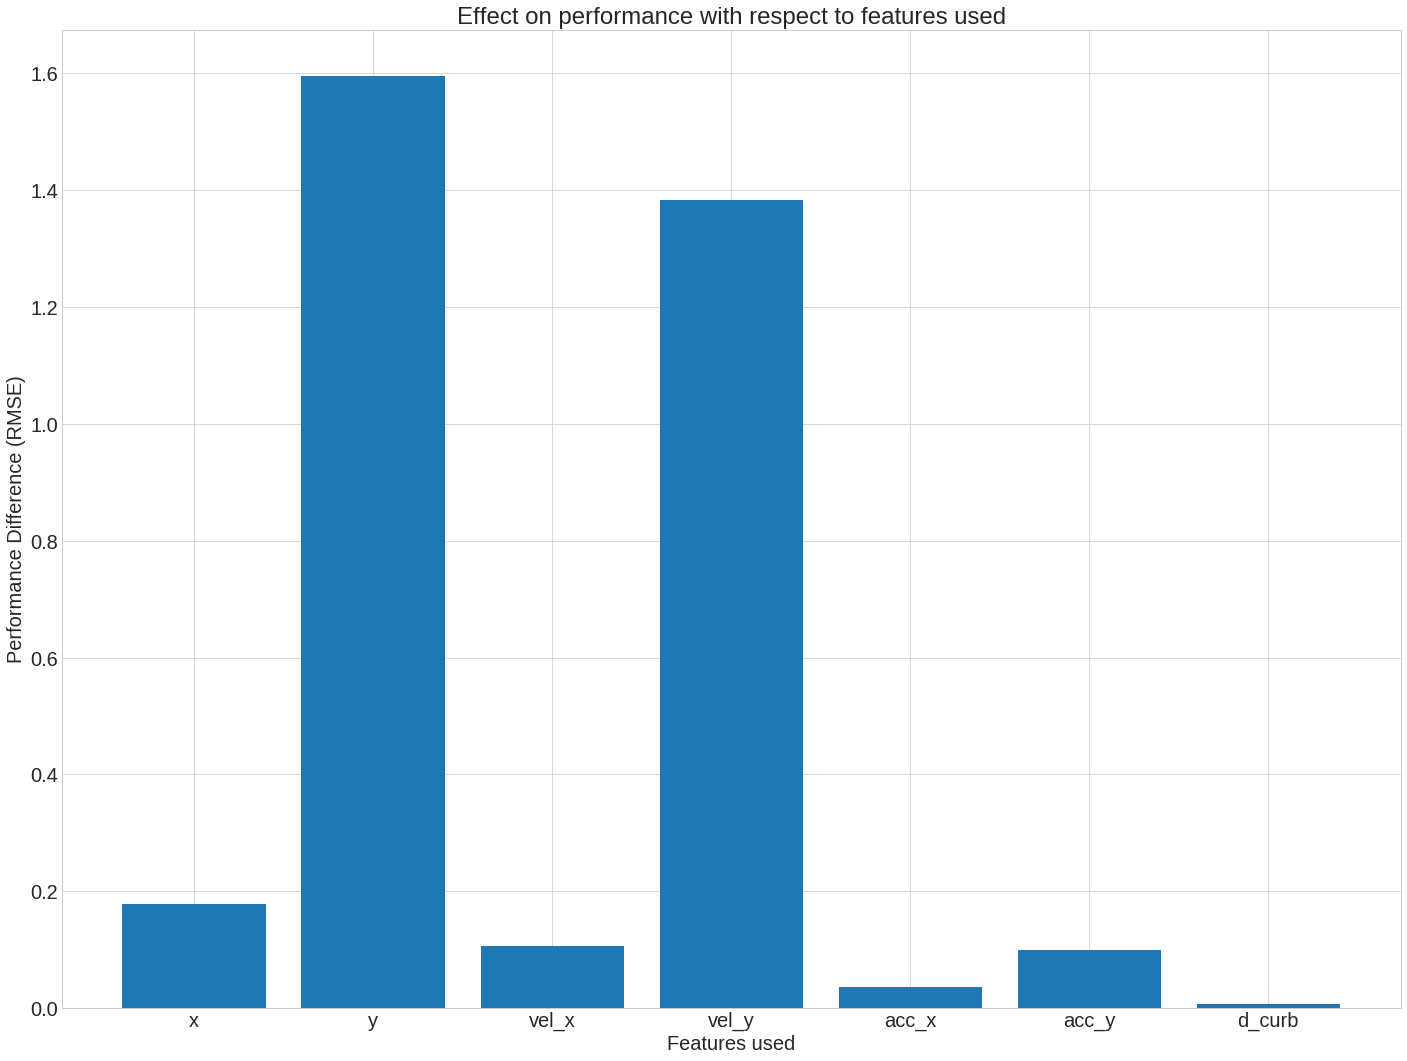

In [24]:
plt.bar(['x','y','vel_x','vel_y','acc_x','acc_y','d_curb'],
        feature_importance)
plt.title("Effect on performance with respect to features used")
plt.xlabel("Features used")
plt.ylabel("Performance Difference (RMSE)")
plt.savefig("../images/feature_analysis.png", bbox_inches='tight', pad_inches=1)
plt.show()